In [ ]:
! pip install transformers
! pip install datasets
! pip install pythainlp
! pip install python-crfsuite
! pip install sentencepiece
! pip install keras-crf
! pip install git+https://www.github.com/keras-team/keras-contrib.git
! pip install tf2crf
! pip install keras
! pip install seqeval
! pip install sklearn_crfsuite
! pip install pyyaml h5py

In [ ]:
import numpy as np
import pandas as pd
import datasets
import re
import matplotlib.pyplot as plt
import tensorflow as tf

# Preprocessing

In [ ]:
ner_tag = [
        "O",
        "B_BRN",
        "B_DES",
        "B_DTM",
        "B_LOC",
        "B_MEA",
        "B_NUM",
        "B_ORG",
        "B_PER",
        "B_TRM",
        "B_TTL",
        "I_BRN",
        "I_DES",
        "I_DTM",
        "I_LOC",
        "I_MEA",
        "I_NUM",
        "I_ORG",
        "I_PER",
        "I_TRM",
        "I_TTL",
        "E_BRN",
        "E_DES",
        "E_DTM",
        "E_LOC",
        "E_MEA",
        "E_NUM",
        "E_ORG",
        "E_PER",
        "E_TRM",
        "E_TTL",
    ]

In [ ]:
id_to_ner = {}
for i in ner_tag:
    # ner_tag_dict[i] = ner_tag.index(i)
    id_to_ner[ner_tag.index(i)] = i
# id_to_ner

In [ ]:
ner_to_id = {}
for i in ner_tag:
    ner_to_id[i] = ner_tag.index(i)
    # id_to_ner[ner_tag.index(i)] = i
# ner_to_id

In [ ]:
def idx_to_ner(idx, id_to_ner):
    ret = []
    for i in idx:
        ret.append(id_to_ner[i])
    return ret 

In [ ]:
def ner_to_idx(ner, ner_to_id):
    ret = []
    for i in ner:
        ret.append(ner_to_id[i])
    return ret

# Download dataset

In [ ]:
dataset = datasets.load_dataset("lst20", data_dir='/content/drive/MyDrive/Super-AI-Engineer/nlp-hackathon/LST20_Corpus')

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset lst20 downloaded and prepared to /root/.cache/huggingface/datasets/lst20/default-d3fa84b1b6df7959/0.0.0/e1b2a921fb011578ab43ddbbf789f3c500d62cb2df8ae4ed4b60bae8e4c0d3ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# train_df = pd.DataFrame(dataset['train'])
# val_df = pd.DataFrame(dataset['validation'])
# test_df = pd.DataFrame(dataset['test'])

In [ ]:
# df = pd.concat([train_df, val_df, test_df])
df = pd.concat([pd.DataFrame(dataset['train']),
                pd.DataFrame(dataset['validation']),
                pd.DataFrame(dataset['test'])])
df['len_token'] = [len(i) for i in df.tokens.values]
df = df[df['len_token'] <= 100]
df.head()

,id,fname,tokens,pos_tags,ner_tags,clause_tags,len_token
0,0,T00126.txt,"[สุรยุทธ์, ยัน, ปฏิเสธ, ลงนาม, _, MOU, _, กับ,...","[0, 1, 1, 1, 2, 0, 2, 4, 0, 12, 1, 0]","[8, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0]","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3]",12
1,1,T00126.txt,"[1, _, กันยายน, _, 2550, _, 12:21, _, น.]","[8, 2, 0, 2, 8, 2, 8, 2, 10]","[3, 13, 13, 13, 23, 0, 3, 13, 23]","[1, 2, 2, 2, 2, 2, 2, 2, 3]",9
2,2,T00126.txt,"[นายก, ฯ, _, ย้ำ, ไม่, ลงนาม, ใน, _, MOU, _, ร...","[0, 2, 2, 1, 12, 1, 4, 2, 0, 2, 4, 0, 3, 5, 6,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, ...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, ...",26
3,3,T00126.txt,"[ยัน, ไทย, ไม่, ได้, ล้มเหลว, ถึง, ขั้น, นั้น,...","[1, 0, 12, 5, 1, 1, 0, 9, 1, 7, 1, 0, 9, 12, 1...","[0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",20
4,4,T00126.txt,"[พร้อม, หนุน, กกต., จัด, เลือกตั้ง, ให้, บริสุ...","[3, 1, 0, 1, 1, 3, 1, 1]","[0, 0, 7, 0, 0, 0, 0, 0]","[1, 2, 2, 2, 3, 1, 2, 3]",8


In [ ]:
len(df)

70922

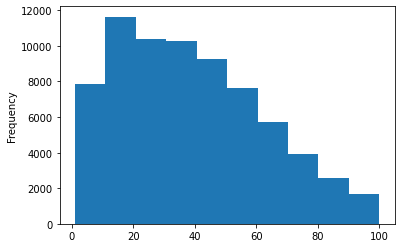

In [ ]:
df.len_token.plot.hist()

In [ ]:
tokens = []
for i in df.tokens:
    for j in i:
        tokens.append(j)

len(tokens)

2751642

In [ ]:
ner_label = []
for i in df.ner_tags:
    for j in i:
        ner_label.append(j)

len(ner_label)

2751642

In [ ]:
words = list(set(tokens))
n_words = len(words)

tags = []
for tag in set(ner_label):
    tags.append(tag)
n_tags = len(tags)

In [ ]:
from future.utils import iteritems

word2idx = {w: i for i, w in enumerate(words)}
idx2tag = id_to_ner
tag2idx = ner_to_id

# Vectorize

In [ ]:
from keras.preprocessing import sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

maxlen = max([len(s) for s in df.tokens])

X = [[word2idx[w] for w in s] for s in df.tokens]
# X = tf.keras.utils.pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)
X = tf.keras.utils.pad_sequences(maxlen=maxlen, sequences=X, padding="post")


y = [[w for w in s] for s in df.ner_tags]
# y = tf.keras.utils.pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])
y = tf.keras.utils.pad_sequences(maxlen=maxlen, sequences=y, padding="post")
y = [to_categorical(i, num_classes=n_tags) for i in y]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(len(X_train), len(X_test), len(y_train), len(y_test))

56737 14185 56737 14185


# Create model

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode


class CRF(L.Layer):
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """    
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim) 
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None

    def build(self, input_shape):
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask

    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    def compute_output_shape(self, input_shape):
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras import Model
import keras as k
# from keras_contrib.layers import CRF
# from tensorflow_addons.layers import CRF
# from tf2crf import CRF, ModelWithCRFLoss

input = Input(shape=(maxlen,))
word_embedding_size = 128

# Embedding Layer
model = Embedding(input_dim=n_words,
                  output_dim=word_embedding_size,
                  input_length=140,
                  mask_zero=True
                  )(input)

# BI-LSTM Layer
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model)

model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)

# TimeDistributed Layer
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  

# CRF Layer
crf = CRF(n_tags)
output = crf(model)
model = Model(input, output)
# model = ModelWithCRFLoss(base_model, sparse_target=True)
# model.compile(optimizer='adam')
# crf = CRF(n_tags)

# out = crf(model)  # output
# model = Model(input, out)

In [ ]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

#Optimiser 
adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

# Compile model
model.compile(optimizer=adam, loss=crf.loss, metrics=crf.accuracy)
# model.compile(optimizer=adam)

model.summary()

# Saving the best model only
filepath="/content/drive/MyDrive/Super-AI-Engineer/nlp-hackathon/lst20-ner-bilstm-crf-model-02.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_viterbi_accuracy', verbose=1, save_best_only=True, mode='max')
stopping = tf.keras.callbacks.EarlyStopping(monitor='val_viterbi_accuracy', patience=3)
callbacks_list = [checkpoint, stopping]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 128)          6434432   
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 256)         263168    
 nal)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 100, 256)          525312    
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 31)          7967      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 100, 31)           961 

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Fit the best model
train_hist = model.fit(X_train, np.array(y_train), batch_size=256, epochs=20, validation_split=0.1, verbose=1, callbacks=callbacks_list)

Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 21.1165 - viterbi_accuracy: 0.9292
Epoch 1: val_viterbi_accuracy improved from -inf to 0.93507, saving model to /content/drive/MyDrive/Super-AI-Engineer/nlp-hackathon/lst20-ner-bilstm-crf-model-02.hdf5
200/200 [==============================] - 347s 2s/step - loss: 21.1165 - viterbi_accuracy: 0.9292 - val_loss: 226.6981 - val_viterbi_accuracy: 0.9351
Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 12.8594 - viterbi_accuracy: 0.9358
Epoch 2: val_viterbi_accuracy improved from 0.93507 to 0.94029, saving model to /content/drive/MyDrive/Super-AI-Engineer/nlp-hackathon/lst20-ner-bilstm-crf-model-02.hdf5
200/200 [==============================] - 324s 2s/step - loss: 12.8594 - viterbi_accuracy: 0.9358 - val_loss: 223.3631 - val_viterbi_accuracy: 0.9403
Epoch 3/20
200/200 [==============================] - ETA: 0s - loss: 9.4579 - viterbi_accuracy: 0.9430
Epoch 3: val_viterbi_accuracy improved from 0.9

In [ ]:
# model.save('/content/drive/MyDrive/Super-AI-Engineer/nlp-hackathon/lst20-ner-bilstm-crf-model-02.hdf5')

# Evaluate

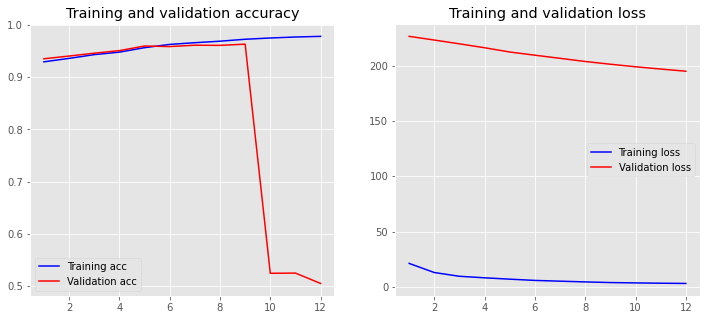

In [ ]:
# Plot the graph 
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['viterbi_accuracy']
    val_accuracy = history.history['val_viterbi_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(train_hist)

In [ ]:
# Load the previously saved weights
model.load_weights('/content/drive/MyDrive/Super-AI-Engineer/nlp-hackathon/lst20-ner-bilstm-crf-model-02.hdf5')

In [ ]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
test_pred = model.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

444/444 [==============================] - 66s 147ms/step


In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_MEA seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_MEA seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: E_MEA seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_LOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: E_LOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171:

F1-score: 60.2%


In [ ]:
# from  sklearn_crfsuite.metrics import flat_classification_report  
# from sklearn_crfsuite.utils import flatten
from sklearn.metrics import classification_report
report = classification_report(np.array(test_labels).flatten(), np.array(pred_labels).flatten())
# report = flat_classification_report(y_true=test_labels, y_pred=pred_labels, )
print(report)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B_BRN       0.00      0.00      0.00        96
       B_DES       0.85      0.83      0.84      3755
       B_DTM       0.78      0.73      0.75      3490
       B_LOC       0.62      0.31      0.42      7648
       B_MEA       0.49      0.78      0.60      7547
       B_NUM       0.00      0.00      0.00      3112
       B_ORG       0.71      0.75      0.73     10741
       B_PER       0.92      0.88      0.90      9824
       B_TRM       0.00      0.00      0.00       203
       B_TTL       0.96      0.91      0.93      4354
       E_BRN       0.00      0.00      0.00        20
       E_DES       0.00      0.00      0.00       428
       E_DTM       0.78      0.72      0.75      2988
       E_LOC       0.82      0.28      0.41      3435
       E_MEA       0.57      0.45      0.50      2271
       E_NUM       0.00      0.00      0.00       246
       E_ORG       0.62      0.47      0.54      4919
       E_PER       0.89    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# df.ner_tags.values.flatten().value_counts()
np.unique(ner_label, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 array([2291490,     495,   18473,   16701,   37156,   36674,   15158,
          53132,   49648,    1104,   21830,     116,    2567,   37460,
           8243,   13255,    1822,   33458,   22015,     374,     327,
            107,    2106,   14159,   16463,   10687,    1119,   24747,
          20339,     313,     104]))

# Test submit

In [ ]:
with open('/content/drive/MyDrive/Super-AI-Engineer/nlp-hackathon/ss3-hackathon-online-natural-language-processing/ne_test.txt') as f:
    ne_test = f.read().split('\n')

for i in range(len(ne_test)):
    if ne_test[i] == '':
        ne_test[i] = '_'

ne_test[:10]

['นาง',
 'สุดารัตน์',
 '_',
 'เกยุราพันธ์',
 '_',
 'รมว.',
 'สาธารณสุข',
 '_',
 'แถลง',
 'ถึง']

In [ ]:
max(list(word2idx.values()))

50268

In [ ]:
submit_test = []
for w in ne_test:
    if w not in word2idx.keys():
        submit_test.append(np.random.choice(range(0, max(list(word2idx.values())))))
        # word2idx[w] = max(list(word2idx.values())) + 1
    else:
        submit_test.append(word2idx[w])

submit_test[:10]

[7582, 31221, 6224, 41667, 6224, 11492, 44540, 6224, 40224, 37635]

In [ ]:
max(submit_test)

50266

In [ ]:
def split_sentence(sentence, maxlen):
    ret = []
    for i in range(0, len(sentence), maxlen):
        try:
            ret.append(sentence[i:i+maxlen])
        except:
            ret.append(sentence[i:])
    return ret

split_test = split_sentence(submit_test, maxlen)
split_test = tf.keras.utils.pad_sequences(maxlen=maxlen, sequences=split_test, padding="post", value=max(submit_test) - 1)

In [ ]:
num_padded = len(split_test.flatten()) - len(submit_test)
num_padded

37

In [ ]:
submit_pred = model.predict(split_test, verbose=1)   

22/22 [==============================] - 3s 148ms/step


In [ ]:
submit_labels = pred2label(submit_pred)
submit_labels = np.array(submit_labels).flatten()[:69561]
submit_labels.shape

(69561,)

In [ ]:
submit_df = pd.DataFrame({'Id': range(1, len(submit_labels)+1), 'Predicted': submit_labels})
submit_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from 

,Id,Predicted
0,1,B_TTL
1,2,B_PER
2,3,I_PER
3,4,E_PER
4,5,O
...,...,...
69556,69557,O
69557,69558,O
69558,69559,O
69559,69560,O


In [ ]:
submit_df.to_csv('/content/drive/MyDrive/Super-AI-Engineer/nlp-hackathon/submit-01.csv', index=False)